In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn import cross_decomposition
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.datasets import make_blobs
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier


sns.set()

%matplotlib inline


#Tamaño de figura predeterminado
sns.set(rc={"figure.figsize": (12, 6)})

#En realidad, esto hace que el autocompletado sea mucho más rápido
%config Completer.use_jedi = False

# Mostrar solo 2 decimales para números de coma flotante
pd.options.display.float_format = "{:.2f}".format

sns.set_style('whitegrid')

In [2]:
df = pd.read_csv('crypto-marketss.csv')

In [3]:
df.head()

,slug,symbol,name,date,ranknow,open,high,low,close,volume,market,close_ratio,spread
0,bitcoin,BTC,Bitcoin,2013-04-28,1,135.30,135.98,132.10,134.21,0.00,1488566728.00,0.54,3.88
1,bitcoin,BTC,Bitcoin,2013-04-29,1,134.44,147.49,134.00,144.54,0.00,1603768865.00,0.78,13.49
2,bitcoin,BTC,Bitcoin,2013-04-30,1,144.00,146.93,134.05,139.00,0.00,1542813125.00,0.38,12.88
3,bitcoin,BTC,Bitcoin,2013-05-01,1,139.00,139.89,107.72,116.99,0.00,1298954594.00,0.29,32.17
4,bitcoin,BTC,Bitcoin,2013-05-02,1,116.38,125.60,92.28,105.21,0.00,1168517495.00,0.39,33.32


In [4]:
#Análisis exploratorio de datos

df.describe()

,ranknow,open,high,low,close,volume,market,close_ratio,spread
count,942297.00,942297.00,942297.00,942297.00,942297.00,942297.00,942297.00,942297.00,942297.00
mean,1000.17,348.35,408.59,296.25,346.10,8720383.29,172505976.17,0.46,112.34
std,587.58,13184.36,16163.86,10929.31,13098.22,183980157.98,3575589517.51,0.33,6783.71
min,1.00,0.00,0.00,0.00,0.00,0.00,0.00,-1.00,0.00
25%,465.00,0.00,0.00,0.00,0.00,175.00,29581.00,0.16,0.00
50%,1072.00,0.02,0.03,0.02,0.02,4278.00,522796.00,0.43,0.00
75%,1484.00,0.23,0.25,0.20,0.23,119090.00,6874647.00,0.75,0.03
max,2072.00,2298390.00,2926100.00,2030590.00,2300740.00,23840899072.00,326502485530.00,1.00,1770563.00


In [5]:
df.shape, df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 942297 entries, 0 to 942296
Data columns (total 13 columns):
slug           942297 non-null object
symbol         942297 non-null object
name           942297 non-null object
date           942297 non-null object
ranknow        942297 non-null int64
open           942297 non-null float64
high           942297 non-null float64
low            942297 non-null float64
close          942297 non-null float64
volume         942297 non-null float64
market         942297 non-null float64
close_ratio    942297 non-null float64
spread         942297 non-null float64
dtypes: float64(8), int64(1), object(4)
memory usage: 93.5+ MB


((942297, 13), None)

Las descripciones de algunas de las columnas:

volume - Volumen de transacciones
market - Market Cap
ranknow - Rango de moneda

Una cosa que noté: los límites de mercado son bastante grandes. Para facilitar la observación, introduzcamos una nueva columna: market_billion, que representará las divisas Market Cap en miles de millones

In [6]:
#Convertir fecha a fecha real

df['date'] = pd.to_datetime(df['date'])
df['market_billion'] = df['market'] / 1000000000
df['volume_million'] = df['volume'] / 1000000000
df['volume_billion'] = df['volume']

In [7]:
#Vamos a preparar un marco de datos donde observaremos los precios de cierre de cada moneda.

wide_format = df.groupby(['date', 'name'])['close'].last().unstack()
wide_format.head(3)

name,0chain,0x,0xBitcoin,0xcert,1World,2GIVE,300 Token,42-coin,4NEW,808Coin,...,imbrex,indaHash,nDEX,nUSD,savedroid,smARTOFGIVING,ugChain,vSlice,vSportCoin,wys Token
date,,,,,,,,,,,,,,,,,,,,,
2013-04-28,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2013-04-29,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2013-04-30,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan


In [8]:
wide_format.shape

(2043, 2071)

In [9]:
wide_format.describe()

name,0chain,0x,0xBitcoin,0xcert,1World,2GIVE,300 Token,42-coin,4NEW,808Coin,...,imbrex,indaHash,nDEX,nUSD,savedroid,smARTOFGIVING,ugChain,vSlice,vSportCoin,wys Token
count,151.00,471.00,179.00,141.00,254.00,928.00,479.00,1767.00,100.00,857.00,...,419.00,310.00,52.00,140.00,109.00,70.00,321.00,704.00,79.00,128.00
mean,0.23,0.76,0.75,0.01,0.16,0.00,431.59,16060.95,0.04,0.00,...,0.36,0.05,0.00,0.99,0.00,0.10,0.04,0.23,0.00,0.02
std,0.13,0.46,0.58,0.01,0.07,0.01,248.35,46399.77,0.02,0.00,...,0.40,0.07,0.00,0.01,0.00,0.02,0.04,0.29,0.00,0.01
min,0.08,0.17,0.27,0.00,0.06,0.00,112.65,20.72,0.02,0.00,...,0.05,0.00,0.00,0.96,0.00,0.05,0.00,0.00,0.00,0.00
25%,0.14,0.37,0.43,0.00,0.10,0.00,216.82,500.08,0.03,0.00,...,0.14,0.01,0.00,0.99,0.00,0.10,0.01,0.06,0.00,0.01
50%,0.19,0.71,0.56,0.01,0.15,0.00,380.05,1648.15,0.04,0.00,...,0.23,0.02,0.00,0.99,0.00,0.11,0.03,0.10,0.00,0.02
75%,0.26,0.99,0.87,0.01,0.20,0.01,576.62,19514.85,0.04,0.00,...,0.40,0.05,0.00,1.00,0.00,0.12,0.05,0.24,0.00,0.03
max,0.62,2.37,4.33,0.04,0.44,0.04,1461.65,793273.00,0.11,0.00,...,3.21,0.61,0.00,1.01,0.00,0.13,0.18,1.17,0.00,0.06


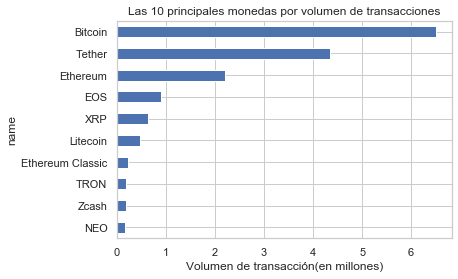

In [10]:
#Las 10 principales criptomonedas en 2018

ax = df.groupby(['name'])['volume_million'].last().sort_values(ascending=False).head(10).sort_values().plot(kind='barh');
ax.set_xlabel('Volumen de transacción(en millones)');
plt.title('Las 10 principales monedas por volumen de transacciones');

In [11]:
#Por conveniencia, definamos las 5 monedas principales

top_5_currency_names = df.groupby(['name'])['market'].last().sort_values(ascending=False).head(5).index
data_top_5_currencies = df[df['name'].isin(top_5_currency_names)]
data_top_5_currencies.head(5)


,slug,symbol,name,date,ranknow,open,high,low,close,volume,market,close_ratio,spread,market_billion,volume_million,volume_billion
0,bitcoin,BTC,Bitcoin,2013-04-28,1,135.30,135.98,132.10,134.21,0.00,1488566728.00,0.54,3.88,1.49,0.00,0.00
1,bitcoin,BTC,Bitcoin,2013-04-29,1,134.44,147.49,134.00,144.54,0.00,1603768865.00,0.78,13.49,1.60,0.00,0.00
2,bitcoin,BTC,Bitcoin,2013-04-30,1,144.00,146.93,134.05,139.00,0.00,1542813125.00,0.38,12.88,1.54,0.00,0.00
3,bitcoin,BTC,Bitcoin,2013-05-01,1,139.00,139.89,107.72,116.99,0.00,1298954594.00,0.29,32.17,1.30,0.00,0.00
4,bitcoin,BTC,Bitcoin,2013-05-02,1,116.38,125.60,92.28,105.21,0.00,1168517495.00,0.39,33.32,1.17,0.00,0.00


In [12]:
data_top_5_currencies.describe()

,ranknow,open,high,low,close,volume,market,close_ratio,spread,market_billion,volume_million,volume_billion
count,7270.00,7270.00,7270.00,7270.00,7270.00,7270.00,7270.00,7270.00,7270.00,7270.00,7270.00,7270.00
mean,2.52,740.32,765.00,712.85,740.76,660390097.22,17117085085.27,0.50,52.15,17.12,0.66,660390097.22
std,1.29,2084.06,2157.86,1995.59,2084.30,1837334592.36,36759177748.70,0.31,204.62,36.76,1.84,1837334592.36
min,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,1.00,0.01,0.01,0.01,0.01,369596.75,206042906.75,0.23,0.00,0.21,0.00,369596.75
50%,2.00,1.25,1.35,1.17,1.25,23354500.00,3679884846.50,0.50,0.17,3.68,0.02,23354500.00
75%,4.00,451.73,462.62,443.39,451.91,319923000.00,13039122948.75,0.78,18.99,13.04,0.32,319923000.00
max,5.00,19475.80,20089.00,18974.10,19497.40,23840899072.00,326502485530.00,1.00,4110.40,326.50,23.84,23840899072.00


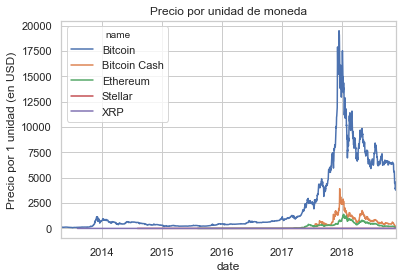

In [13]:
#Gráficos de tendencias

ax = data_top_5_currencies.groupby(['date', 'name'])['close'].mean().unstack().plot();
ax.set_ylabel("Precio por 1 unidad (en USD)");
plt.title("Precio por unidad de moneda");

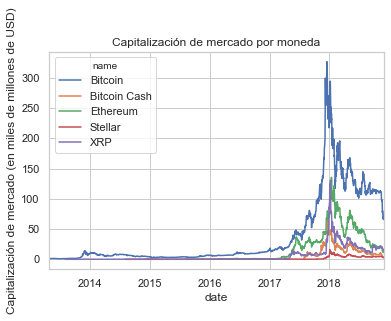

In [14]:
ax = data_top_5_currencies.groupby(['date', 'name'])['market_billion'].mean().unstack().plot();
ax.set_ylabel("Capitalización de mercado (en miles de millones de USD)");
plt.title("Capitalización de mercado por moneda");

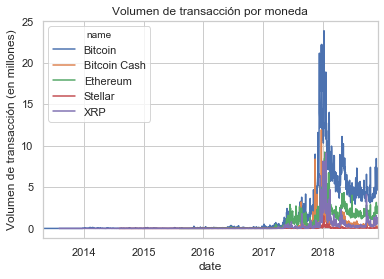

In [15]:
ax = data_top_5_currencies.groupby(['date', 'name'])['volume_million'].mean().unstack().plot();
ax.set_ylabel("Volumen de transacción (en millones)");
plt.title("Volumen de transacción por moneda");

Gráficos de tendencias en 2017

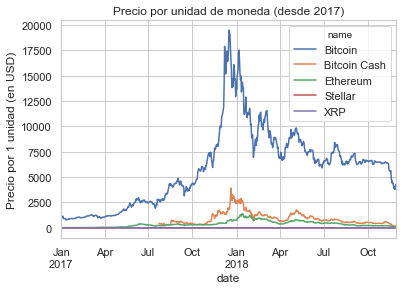

In [16]:
ax = data_top_5_currencies[data_top_5_currencies.date.dt.year >= 2017].groupby(['date', 'name'])['close'].mean().unstack().plot();
ax.set_ylabel("Precio por 1 unidad (en USD)");
plt.title("Precio por unidad de moneda (desde 2017)");

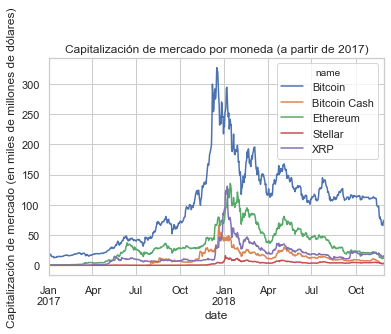

In [17]:
ax = data_top_5_currencies[data_top_5_currencies.date.dt.year >= 2017].groupby(['date', 'name'])['market_billion'].mean().unstack().plot();
ax.set_ylabel("Capitalización de mercado (en miles de millones de dólares)");
plt.title("Capitalización de mercado por moneda (a partir de 2017)");

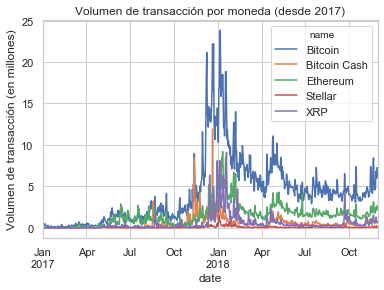

In [18]:
ax = data_top_5_currencies[data_top_5_currencies.date.dt.year >= 2017].groupby(['date', 'name'])['volume_million'].mean().unstack().plot();
ax.set_ylabel("Volumen de transacción (en millones)");
plt.title("Volumen de transacción por moneda (desde 2017)");

Gráficos de tendencias en 2018

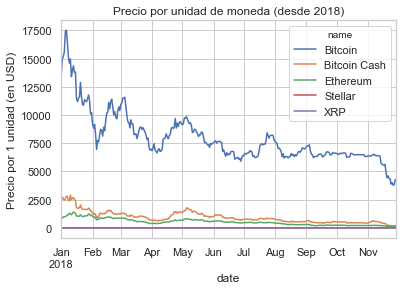

In [19]:
ax = data_top_5_currencies[data_top_5_currencies.date.dt.year >= 2018].groupby(['date', 'name'])['close'].mean().unstack().plot();
ax.set_ylabel("Precio por 1 unidad (en USD)");
plt.title("Precio por unidad de moneda (desde 2018)");

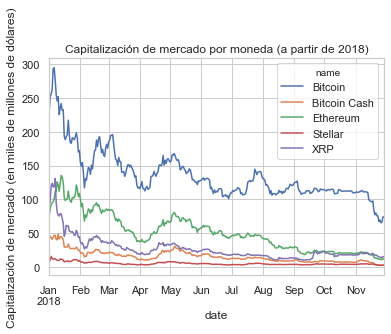

In [20]:
ax = data_top_5_currencies[data_top_5_currencies.date.dt.year >= 2018].groupby(['date', 'name'])['market_billion'].mean().unstack().plot();
ax.set_ylabel("Capitalización de mercado (en miles de millones de dólares)");
plt.title("Capitalización de mercado por moneda (a partir de 2018)");

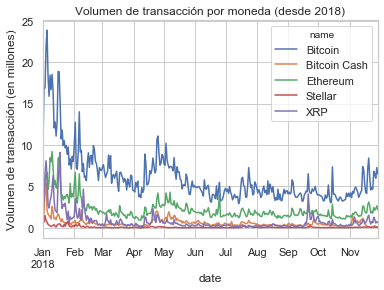

In [21]:
ax = data_top_5_currencies[data_top_5_currencies.date.dt.year >= 2018].groupby(['date', 'name'])['volume_million'].mean().unstack().plot();
ax.set_ylabel("Volumen de transacción (en millones)");
plt.title("Volumen de transacción por moneda (desde 2018)");

Correlación

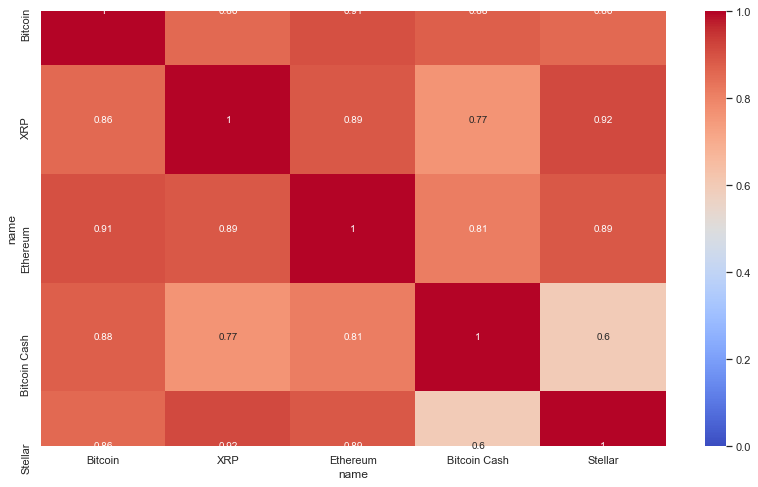

In [22]:
#Hay una fuerte correlación entre las criptomonedas, especialmente entre Bitcoin y Ethereum.
plt.figure(figsize=(14,8))
sns.heatmap(wide_format[top_5_currency_names].corr(),vmin=0, vmax=1, cmap='coolwarm', annot=True);

Experimentos

Pequeño experimento: supongamos que invertimos cierta cantidad (por ejemplo, 1000 USD) en algún momento. Veamos qué ROI tendríamos.

Retorno de la inversión: El retorno sobre la inversión es una razón financiera que compara el beneficio o la utilidad obtenida en relación a la inversión realizada.

In [23]:
def plot_roi(amount, df):
    ((amount / df.iloc[0]) * df).plot(figsize=(12,8))

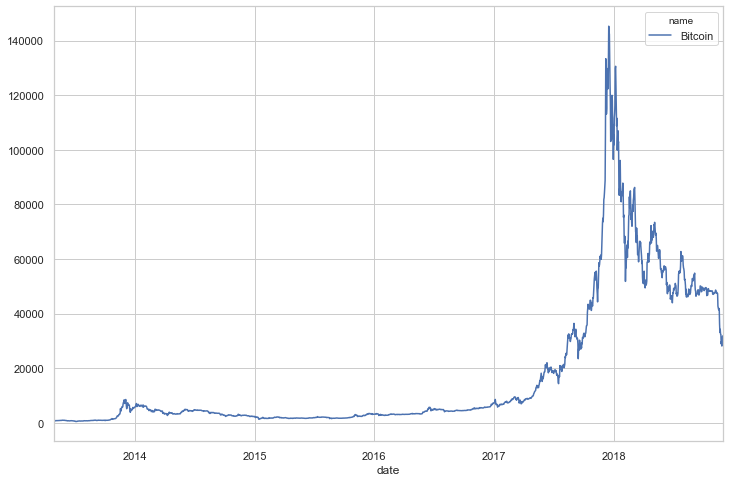

In [24]:
plot_roi(1000, wide_format[['Bitcoin']])

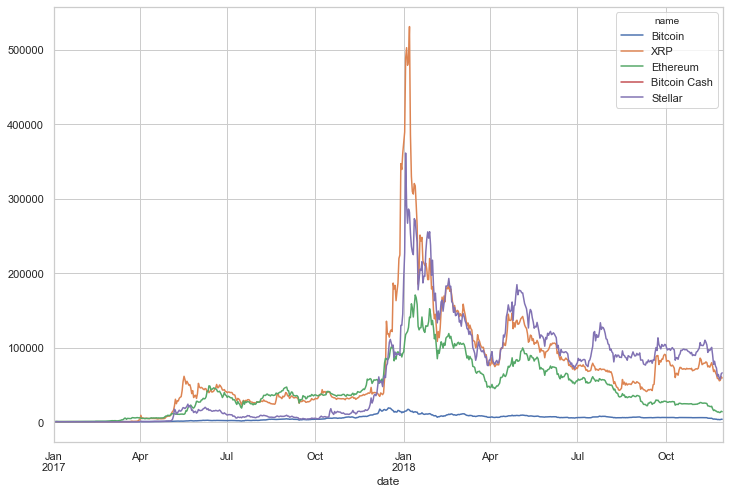

In [25]:
wide_format_2017th = wide_format[(wide_format.index.year >= 2017)]
plot_roi(1000, wide_format_2017th[top_5_currency_names])

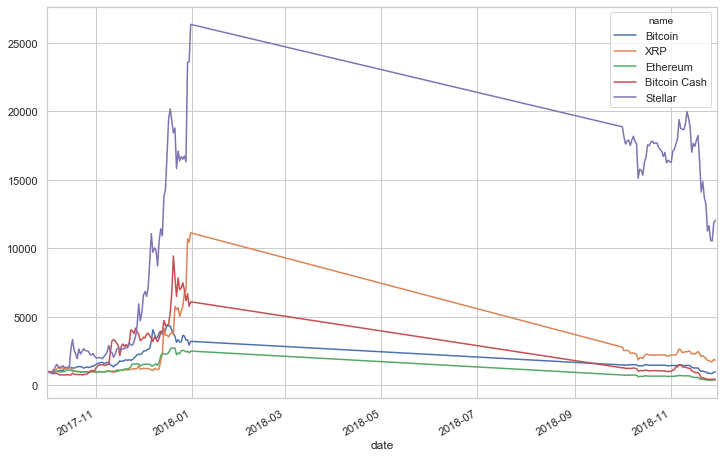

In [26]:
wide_format_late_2017th = wide_format[(wide_format.index.year >= 2017) & (wide_format.index.month >= 10)]
plot_roi(1000, wide_format_late_2017th[top_5_currency_names])

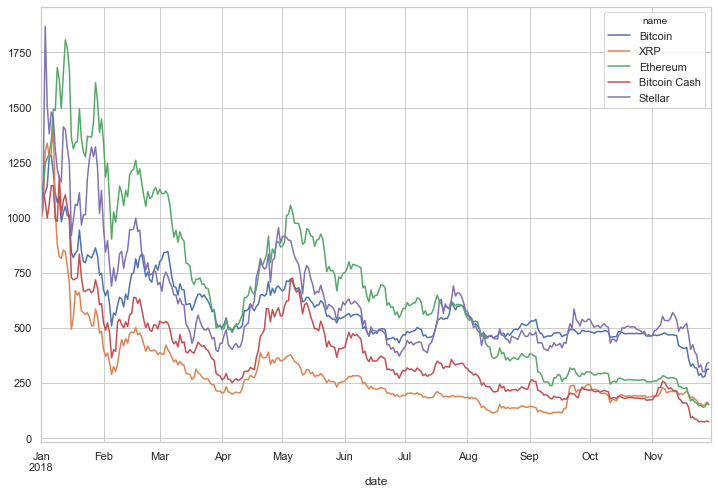

In [27]:
wide_format_2018th = wide_format[(wide_format.index.year >= 2018)]
plot_roi(1000, wide_format_2018th[top_5_currency_names])

In [28]:
len(df.slug.unique())

2071

In [29]:
#Algunos filtros comunes que usaremos

is_bitcoin = df['symbol'] == 'BTC'
is_ethereum = df['symbol'] == 'ETH'
is_ripple  = df['symbol'] == 'XRP'

In [30]:
#Extraemos las monedas más interesantes del conjunto de datos

data_top_currencies = df[is_bitcoin | is_ethereum | is_ripple]

In [31]:
#Tracemos las principales criptomonedas de acuerdo con el último Market Cap reportado

top10Currencies = df.groupby('name')['market_billion'].last().sort_values(ascending=False).head(10)

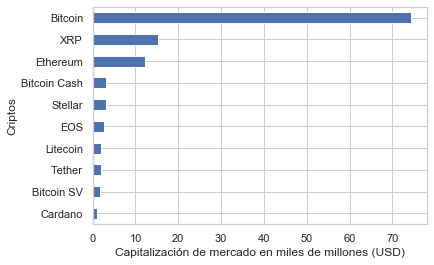

In [32]:
ax = top10Currencies.sort_values().plot(kind='barh')
ax.set_xlabel("Capitalización de mercado en miles de millones (USD)");
ax.set_ylabel("Criptos");


Como podemos ver, y como se esperaba, Bitcoin tiene la capitalización de mercado más alta. Veamos la tendencia de algunas de las principales monedas.

Text(0, 0.5, 'Precio por 1 unidad (en USD)')

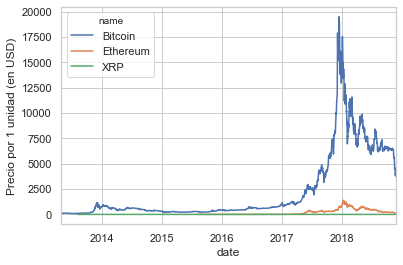

In [33]:
ax = data_top_currencies.groupby(['date', 'name'])['close'].mean().unstack().plot()
ax.set_ylabel("Precio por 1 unidad (en USD)")

Veamos el enfoque en la tendencia a partir de 2018.

Text(17.200000000000003, 0.5, 'Precio por 1 unidad (en USD)')

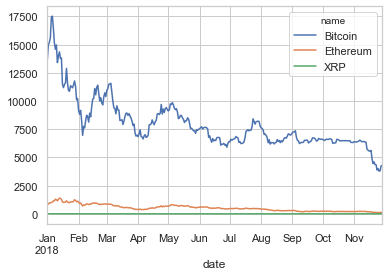

In [34]:
data_top_currencies[data_top_currencies.date.dt.year >= 2018].groupby(['date', 'name'])['close'].mean().unstack().plot()
ax.set_ylabel("Precio por 1 unidad (en USD)")

Podemos ver que los precios han subido enormemente al inicio, luego disminuye fuertemente a principios de febrero, volviendo a subir los primeros días de marzo del 2018. ¿La causa? Aparentemente, hay muchas causas. Desde el mayor conocimiento de las personas sobre las criptomonedas, hasta la introducción de otras monedas que aumentaron la necesidad general.

Veamos una tendencia del volumen de operaciones para las principales monedas ahora

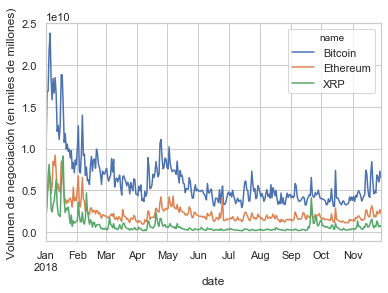

In [35]:
ax = data_top_currencies[data_top_currencies.date.dt.year >= 2018].groupby(['date', 'name'])['volume_billion'].mean().unstack().plot()
ax.set_ylabel("Volumen de negociación (en miles de millones)");

Parece haber una correlación en el comercio entre monedas. Lo que probablemente tiene sentido ya que, si entendí correctamente, la mayoría de las monedas se comercializan con Bitcoin (es decir, debe comprar Bitcoin para comprar Ripple por ejemplo). En aras de la visibilidad, trazaré Bitcoin y otras monedas por separado. La cosa es que los precios de Bitcoin en realidad están enmascarando otras monedas.

Hagamos un pequeño experimento: digamos que invertimos $1000 en cada criptomoneda hace 5 años. Veamos cuánto dinero tendría ahora.

Primero, comencemos dibujando un diagrama de precios de cierre para cada año para cada moneda.

In [36]:
def plot_with_textvalue(df):
    ax = df.plot(kind='bar')
    
    ax.set_ylabel("Precios de cierre anuales (en USD)")

    for rect in ax.patches:
        height = rect.get_height()
        plt.text(rect.get_x() + rect.get_width()/2.0, height, '%d$' % int(height), ha='center', va='bottom')


In [37]:
top10Currencies

name
Bitcoin        74.45
XRP            15.31
Ethereum       12.17
Bitcoin Cash    3.16
Stellar         3.16
EOS             2.74
Litecoin        2.01
Tether          1.85
Bitcoin SV      1.71
Cardano         1.09
Name: market_billion, dtype: float64

In [38]:
closing_prices_bitcoin_and_ethereum = df[is_bitcoin | is_ethereum].groupby(['date','name'])['close'].last().unstack().reset_index()
closing_prices_other_currencies = df[df['name'].isin(top10Currencies.index) & ~is_bitcoin & ~is_ethereum].groupby(['date','name'])['close'].last().unstack().reset_index()

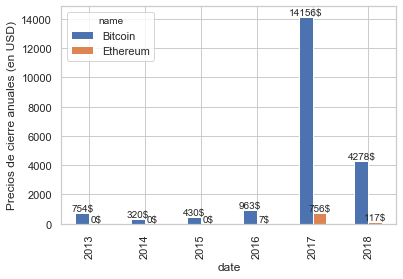

In [39]:
yearly_closing_prices_bitcoin_and_ethereum = closing_prices_bitcoin_and_ethereum.groupby(closing_prices_bitcoin_and_ethereum.date.dt.year).last()
yearly_closing_prices_bitcoin_and_ethereum.drop(columns='date', inplace=True)
plot_with_textvalue(yearly_closing_prices_bitcoin_and_ethereum)

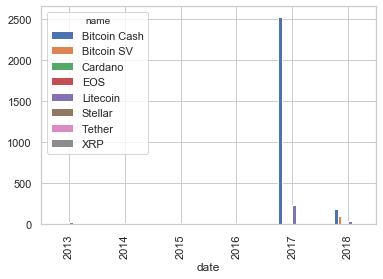

In [40]:
yearly_closing_prices_other_currencies = closing_prices_other_currencies.groupby(closing_prices_other_currencies.date.dt.year).last()
yearly_closing_prices_other_currencies.drop(columns='date', inplace=True)
yearly_closing_prices_other_currencies.plot(kind='bar')

In [41]:
closing_prices_other_currencies.head()

name,date,Bitcoin Cash,Bitcoin SV,Cardano,EOS,Litecoin,Stellar,Tether,XRP
0,2013-04-28,nan,nan,nan,nan,4.35,nan,nan,nan
1,2013-04-29,nan,nan,nan,nan,4.38,nan,nan,nan
2,2013-04-30,nan,nan,nan,nan,4.30,nan,nan,nan
3,2013-05-01,nan,nan,nan,nan,3.80,nan,nan,nan
4,2013-05-02,nan,nan,nan,nan,3.37,nan,nan,nan


Tracemos los precios de cierre.

In [42]:
closing_prices_bitcoin_and_ethereum.head()

name,date,Bitcoin,Ethereum
0,2013-04-28,134.21,nan
1,2013-04-29,144.54,nan
2,2013-04-30,139.00,nan
3,2013-05-01,116.99,nan
4,2013-05-02,105.21,nan


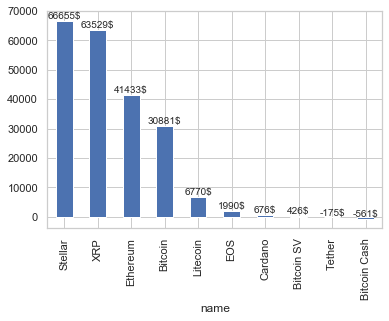

In [43]:
def calc_earnings(currency_name, df):
    #print("Displaying stats for "+currency_name)

    closing_prices = df[(df['name'] == currency_name) & (~df['close'].isnull())][['date', 'close']]

    # Num. currency purchased for 1000$
    #print("Closing price at the beginning: " + str(closing_prices.iloc[0]['close']))

    num_units_purchased = 1000 / closing_prices.iloc[0]['close']
    num_units_purchased

    #print("Num. units purchased: " + str(num_units_purchased))

    # Current value
    last_price = closing_prices.iloc[-1]['close']
    #print("Last price: " + str(last_price))

    amount_earned = (num_units_purchased * last_price) - 1000

    #print("Amount you would have earned: " + str(amount_earned) + "$")
    
    return amount_earned
    
# Borrow the index :-)
top_10_currencies_earnings = top10Currencies

for currency in top10Currencies.index:
    top_10_currencies_earnings[currency] = calc_earnings(currency, df)
    
ax = top_10_currencies_earnings.sort_values(ascending=False).plot(kind='bar')
for rect in ax.patches:
        height = rect.get_height()
        plt.text(rect.get_x() + rect.get_width()/2.0, height, '%d$' % int(height), ha='center', va='bottom')

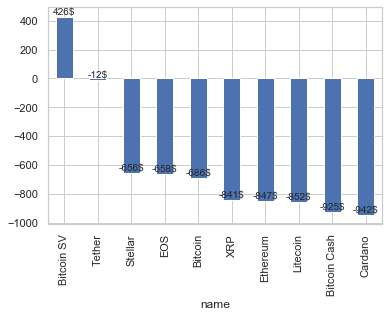

In [44]:
# Pedir prestado el índice :-)
top_10_currencies_earnings_2018 = top10Currencies

for currency in top10Currencies.index:
    top_10_currencies_earnings_2018[currency] = calc_earnings(currency, df[df.date.dt.year >= 2018])
    
top_10_currencies_earnings_2018

ax = top_10_currencies_earnings_2018.sort_values(ascending=False).plot(kind='bar')
for rect in ax.patches:
        height = rect.get_height()
        plt.text(rect.get_x() + rect.get_width()/2.0, height, '%d$' % int(height), ha='center', va='bottom')


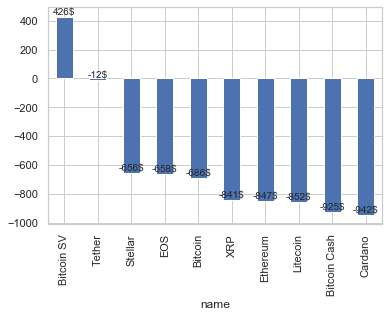

In [45]:
top_10_currencies_earnings_without_nem = top_10_currencies_earnings[top_10_currencies_earnings.index != 'NEM']

ax = top_10_currencies_earnings_without_nem.sort_values(ascending=False).plot(kind='bar')
for rect in ax.patches:
        height = rect.get_height()
        plt.text(rect.get_x() + rect.get_width()/2.0, height, '%d$' % int(height), ha='center', va='bottom')

Text(0.5, 1, 'Mapa de calor de correlación entre Bitcoin y otras 4 criptomonedas principales')

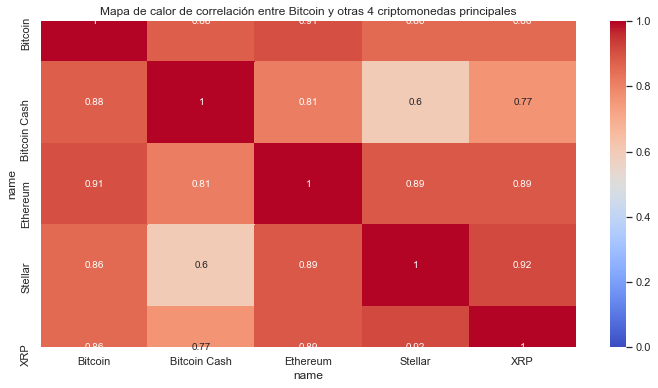

In [46]:
top10Currencies = df.groupby('name')['market_billion'].last().sort_values(ascending=False).head(5)
closing_prices_top10 = df[df['name'].isin(top10Currencies.index)].groupby(['date', 'name'])['close'].mean().unstack()
closing_prices_top10.corr()

plt.figure(figsize=(12,6))
sns.heatmap(closing_prices_top10.corr(),vmin=0, vmax=1, cmap='coolwarm', annot=True)
plt.title('Mapa de calor de correlación entre Bitcoin y otras 4 criptomonedas principales')

Predicciones


Probemos algo: tomemos valores de 3 días anteriores y predijamos si el precio va a subir o bajar

In [47]:
test = df[df['name'] == 'Bitcoin'].copy()

In [48]:
test['price_diff_d1'] = 0 # Hace 1 día
test['price_diff_d2'] = 0 # Hace 2 días
test['price_diff_d3'] = 0 # Hace 3 días

test['trend'] = 0 # 0 = sin cambio, -1 = precio bajado, 1 = precio aumentado

In [49]:
for i, row in test.iterrows():
    for j in range(1, 4):
        if ((i-j) < 0):
            # Saltar filas al principio
            continue
   
        current_price  = row['close']
        prev_price = test.iloc[(i-j)]['close']
        
        column = 'price_diff_d'+str(j)
        
        test.ix[i, column] = (current_price - prev_price)
        
    if (i > 0):
        test.ix[i, 'trend'] = 1 if current_price > test.loc[(i-1)]['close'] else -1

C:\Users\Usuario\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  if sys.path[0] == '':
C:\Users\Usuario\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  from ipykernel import kernelapp as app


In [50]:
X = test[['close', 'price_diff_d1', 'price_diff_d2', 'price_diff_d3']]
y = test['trend']

In [51]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [52]:
X_train.head(10)

,close,price_diff_d1,price_diff_d2,price_diff_d3
1768,10951.00,553.10,225.40,584.30
1068,416.73,1.91,0.21,-7.50
1081,423.73,-1.46,1.25,2.17
1073,424.03,2.59,3.13,3.16
1471,1723.35,126.64,144.55,167.90
1592,4597.12,220.59,360.81,14.16
1169,649.36,-1.60,-17.16,8.80
322,631.11,-5.01,2.31,-7.03
1060,418.04,-0.05,4.73,4.28
574,367.57,14.65,16.72,9.73


In [53]:
X_test.shape, y_train.shape

((613, 4), (1429,))

In [54]:
model = RandomForestClassifier(n_estimators=10, max_depth=None, random_state=1234, oob_score=True)

model.fit(X_train, y_train)

C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:460: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:465: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=True, random_state=1234,
                       verbose=0, warm_start=False)

In [55]:
scores = cross_val_score(model, X, y)
scores.mean()

C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)
C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:460: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:465: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
C:\Users\Usuario\Anaconda3\lib\

0.999021045368294

In [56]:
model.oob_score_

0.9923023093072079

In [57]:
y_pred = model.predict(X_test)

In [58]:
y_pred[-5:]

array([-1, -1,  1, -1, -1], dtype=int64)

In [59]:
test['predicted'] = model.predict(X)

In [60]:
test[['date','predicted', 'trend']]

,date,predicted,trend
0,2013-04-28,-1,0
1,2013-04-29,1,1
2,2013-04-30,-1,-1
3,2013-05-01,-1,-1
4,2013-05-02,-1,-1
...,...,...,...
2037,2018-11-25,1,1
2038,2018-11-26,-1,-1
2039,2018-11-27,1,1
2040,2018-11-28,1,1


In [61]:
test.set_index('date')

,slug,symbol,name,ranknow,open,high,low,close,volume,market,close_ratio,spread,market_billion,volume_million,volume_billion,price_diff_d1,price_diff_d2,price_diff_d3,trend,predicted
date,,,,,,,,,,,,,,,,,,,,
2013-04-28,bitcoin,BTC,Bitcoin,1,135.30,135.98,132.10,134.21,0.00,1488566728.00,0.54,3.88,1.49,0.00,0.00,0.00,0.00,0.00,0,-1
2013-04-29,bitcoin,BTC,Bitcoin,1,134.44,147.49,134.00,144.54,0.00,1603768865.00,0.78,13.49,1.60,0.00,0.00,10.33,0.00,0.00,1,1
2013-04-30,bitcoin,BTC,Bitcoin,1,144.00,146.93,134.05,139.00,0.00,1542813125.00,0.38,12.88,1.54,0.00,0.00,-5.54,4.79,0.00,-1,-1
2013-05-01,bitcoin,BTC,Bitcoin,1,139.00,139.89,107.72,116.99,0.00,1298954594.00,0.29,32.17,1.30,0.00,0.00,-22.01,-27.55,-17.22,-1,-1
2013-05-02,bitcoin,BTC,Bitcoin,1,116.38,125.60,92.28,105.21,0.00,1168517495.00,0.39,33.32,1.17,0.00,0.00,-11.78,-33.79,-39.33,-1,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-11-25,bitcoin,BTC,Bitcoin,1,3880.78,4120.87,3585.06,4009.97,6825640000.00,69749265801.00,0.79,535.81,69.75,6.83,6825640000.00,129.21,-337.14,-355.97,1,1
2018-11-26,bitcoin,BTC,Bitcoin,1,4015.07,4107.14,3643.92,3779.13,6476900000.00,65739289046.00,0.29,463.22,65.74,6.48,6476900000.00,-230.84,-101.63,-567.98,-1,-1
2018-11-27,bitcoin,BTC,Bitcoin,1,3765.95,3862.96,3661.01,3820.72,5998720000.00,66468970322.00,0.79,201.95,66.47,6.00,5998720000.00,41.59,-189.25,-60.04,1,1


In [62]:
test['datetime'] = pd.to_datetime(test['date'])

In [63]:
test = test.set_index('datetime')

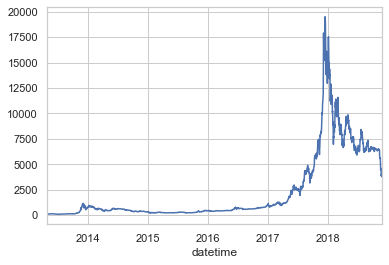

In [64]:
test['close'].plot()